In [1]:
import sys
sys.path.append('../')
import crisprtree
from crisprtree import utils
from crisprtree import estimators
from crisprtree import annotators
from crisprtree import preprocessing

In [2]:
from Bio import SeqIO
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import glob

sbn.set(style = 'white', font_scale = 1.5)
%matplotlib inline

In [3]:
files = sorted(glob.glob('data/GUIDESeq/*/*.tsv'))

data = pd.concat([pd.read_csv(f, sep='\t').reset_index() for f in files], 
                 axis=0, ignore_index=True)
data.columns = list(data.columns[1:]) + ['_']
data[['Filename', 'BED Name', 'Off-Target Sequence', 'Mismatches', 'bi.sum.mi', 'Target Sequence']].dropna().head()


,Filename,BED Name,Off-Target Sequence,Mismatches,bi.sum.mi,Target Sequence
0,EMX1,chr1_23720618_87,AAGTCCGAGGAGAGGAAGAAAGG,3.0,87,GAGTCCGAGCAGAAGAAGAANGG
9,EMX1,chr10_58848728_2,GAGCACGAGCAAGAGAAGAAGGG,4.0,2,GAGTCCGAGCAGAAGAAGAANGG
21,EMX1,chr13_27769657_8,GAGTAGGAGCAGGAGAAGAAGGA,4.0,8,GAGTCCGAGCAGAAGAAGAANGG
22,EMX1,chr15_44109763_1412,GAGTCTAAGCAGAAGAAGAAGAG,3.0,1412,GAGTCCGAGCAGAAGAAGAANGG
25,EMX1,chr15_100292479_7,AAGTCCCGGCAGAGGAAGAAGGG,4.0,7,GAGTCCGAGCAGAAGAAGAANGG


In [4]:
# we only care about hits
hit_data = data.dropna(subset = ['Off-Target Sequence']).copy() 
# remove ones that are the wrong size
hit_data = hit_data.loc[hit_data['Off-Target Sequence'].map(len) == 23, :].copy() 


# Transform bi.sum.mi into a probability
hit_data['NormSum'] = hit_data.groupby('Cells')['bi.sum.mi'].transform(lambda x: x/np.max(x))

# Edit Target Sequence to remove NGG
hit_data['gRNA'] = hit_data['Target Sequence'].map(lambda x: x[:-3])


hit_data[['BED Name', 'Off-Target Sequence', 'Mismatches', 'bi.sum.mi', 'NormSum', 'gRNA']].head()

,BED Name,Off-Target Sequence,Mismatches,bi.sum.mi,NormSum,gRNA
0,chr1_23720618_87,AAGTCCGAGGAGAGGAAGAAAGG,3.0,87,0.018786,GAGTCCGAGCAGAAGAAGAA
9,chr10_58848728_2,GAGCACGAGCAAGAGAAGAAGGG,4.0,2,0.000432,GAGTCCGAGCAGAAGAAGAA
21,chr13_27769657_8,GAGTAGGAGCAGGAGAAGAAGGA,4.0,8,0.001727,GAGTCCGAGCAGAAGAAGAA
22,chr15_44109763_1412,GAGTCTAAGCAGAAGAAGAAGAG,3.0,1412,0.304902,GAGTCCGAGCAGAAGAAGAA
25,chr15_100292479_7,AAGTCCCGGCAGAGGAAGAAGGG,4.0,7,0.001512,GAGTCCGAGCAGAAGAAGAA


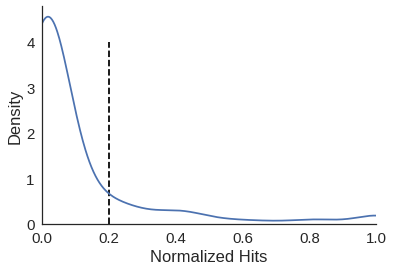

In [5]:
fig, ax = plt.subplots(1,1)

hit_data['NormSum'].plot(kind='kde', ax=ax)
ax.set_xlabel('Normalized Hits')

cutoff = 0.2
ax.vlines(cutoff, 0, 4, linestyle = '--')

ax.set_xlim(0, 1)
ax.set_ylim(0, None)

sbn.despine(ax=ax)

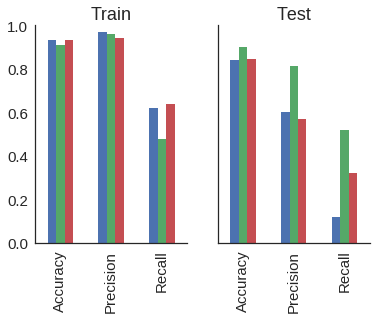

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

X = preprocessing.MatchingTransformer().transform(hit_data[['gRNA', 'Off-Target Sequence']].values)
y = (hit_data['NormSum'] >= cutoff).values

res = cross_validate(GradientBoostingClassifier(), X, y,
                     scoring = ['accuracy', 'precision', 'recall'],
                     cv = StratifiedKFold(),
                     return_train_score=True)
res = pd.DataFrame(res)
fig, (train_ax, test_ax) = plt.subplots(1, 2, sharey=True)

res[['train_accuracy', 'train_precision', 'train_recall']].T.plot(kind='bar', ax=train_ax, legend=False)
res[['test_accuracy', 'test_precision', 'test_recall']].T.plot(kind='bar', ax=test_ax, legend=False)

for name, ax in [('Train', train_ax), 
                 ('Test', test_ax)]:
    ax.set_xticklabels(['Accuracy', 'Precision', 'Recall'])
    ax.set_title(name)
    sbn.despine(ax=ax)
    ax.set_ylim(0, 1)

classif = GradientBoostingClassifier().fit(X, y)
hit_data['GradientBoost'] = classif.predict_proba(X)[:,1]

classif = KNeighborsClassifier().fit(X, y)
hit_data['Neighbors'] = classif.predict_proba(X)[:,1]

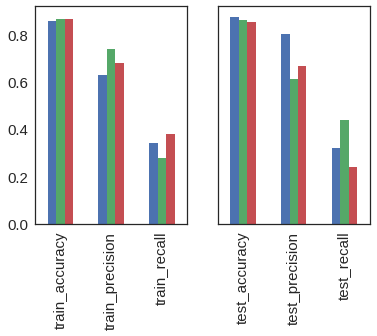

In [10]:
res = cross_validate(estimators.MITEstimator(), X, y,
                     scoring = ['accuracy', 'precision', 'recall'],
                     cv = StratifiedKFold(),
                     return_train_score=True)
res = pd.DataFrame(res)
fig, (train_ax, test_ax) = plt.subplots(1, 2, sharey=True)

res[['train_accuracy', 'train_precision', 'train_recall']].T.plot(kind='bar', ax=train_ax, legend=False)
res[['test_accuracy', 'test_precision', 'test_recall']].T.plot(kind='bar', ax=test_ax, legend=False)

In [7]:
ests = [('MIT', estimators.MITEstimator.build_pipeline()),
        ('CFD', estimators.CFDEstimator.build_pipeline()),
        ('Kinetic', estimators.KineticEstimator.build_pipeline())]

for name, est in ests:
    hit_data[name] = est.predict_proba(hit_data[['gRNA', 'Off-Target Sequence']].values)
    
hit_data[['BED Name', 'Mismatches', 'NormSum', 'MIT', 'CFD', 'Kinetic', 'GradientBoost', 'Neighbors']].head()

,BED Name,Mismatches,NormSum,MIT,CFD,Kinetic,GradientBoost,Neighbors
0,chr1_23720618_87,3.0,0.018786,0.137229,0.163333,0.000151,0.104572,0.0
9,chr10_58848728_2,4.0,0.000432,0.190404,0.225064,0.000036,0.083170,0.2
21,chr13_27769657_8,4.0,0.001727,0.000000,0.012940,0.000000,0.051218,0.2
22,chr15_44109763_1412,3.0,0.304902,0.000000,0.240741,0.000000,0.734942,0.6
25,chr15_100292479_7,4.0,0.001512,0.101767,0.211750,0.000217,0.176817,0.4


Mismatches 3.72766319104
MIT 0.197687336182
CFD 0.19197663222
Kinetic 0.0898762448128
GradientBoost 0.104263873452
Neighbors 0.189583121012


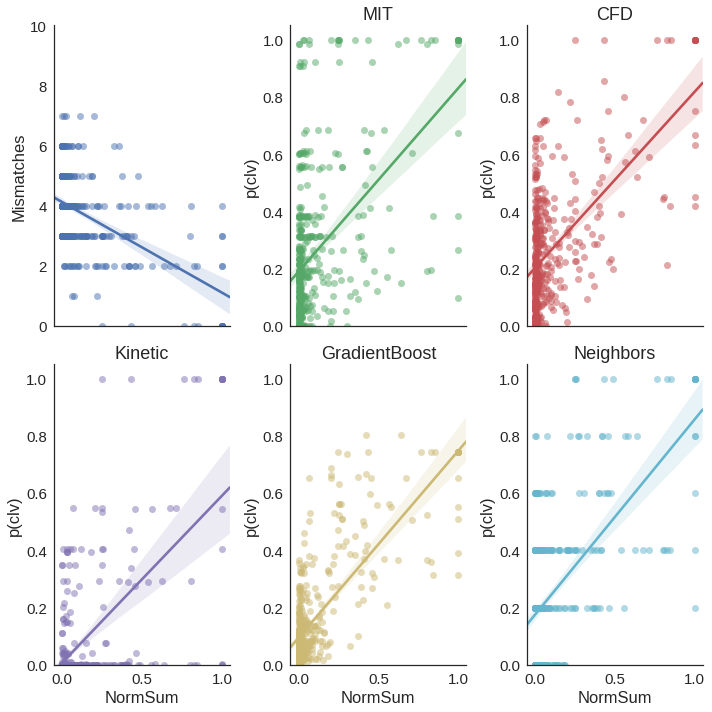

In [8]:
from sklearn.metrics import mean_absolute_error

fig, axs = plt.subplots(2, 3, figsize=(10, 10), sharex=True)

cols = [('Mismatches', 0, 10),
        ('MIT', 0, 1.05), 
        ('CFD', 0, 1.05), 
        ('Kinetic', 0, 1.05),
        ('GradientBoost', 0, 1.05), 
        ('Neighbors', 0, 1.05)]


for ax, (col, ymin, ymax) in zip(axs.flatten(), cols):
    
    sbn.regplot(data = hit_data,
                x = 'NormSum', y = col,
                ax = ax,
                scatter_kws = {'alpha': 0.5})
    print(col, mean_absolute_error(hit_data['NormSum'], hit_data[col]))
    ax.set_ylim(ymin, ymax)
    sbn.despine(ax=ax)
    if col != 'Mismatches':
        ax.set_title(col)
        ax.set_ylabel('p(clv)')
    
    if not ax.is_last_row():
        ax.set_xlabel('')
    
fig.tight_layout()

